In [1]:
%matplotlib inline
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D, Deconvolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Activation
from keras.activations import softmax
from keras.layers.core import Reshape
from keras.callbacks import Callback

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import train_test_split

from experiment import generate_samples, process_label


Using TensorFlow backend.


In [2]:
#burl = '/Users/chiyuan/Documents/home/Train/'
burl = '/ext/data/lyft-challenge/Train'
img_url = os.path.join(burl, "CameraRGB")
label_url = os.path.join(burl, "CameraSeg")

In [3]:
def segnet(num_classes, img_shape):
    model = Sequential()
    num_features = 64
    
    #cropping and pre-process
    #model.add()
    #model.add()
    
    #encoders
    model.add(Conv2D(num_features, nb_row=7, nb_col=7, subsample=(1,1), activation='relu', border_mode='same', input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same'))
    
    model.add(Conv2D(num_features, nb_row=7, nb_col=7, subsample=(1,1), activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same'))
    
    model.add(Conv2D(num_features, nb_row=7, nb_col=7, subsample=(1,1), activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same'))
    
    model.add(Conv2D(num_features, nb_row=7, nb_col=7, subsample=(1,1), activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same'))
    
    #decoders
    model.add(Deconvolution2D(num_features, nb_row=8, nb_col=8, 
              subsample=(2,2), 
              border_mode='same',
              output_shape=(None, img_shape[0]//(2**3), img_shape[1]//(2**3), num_features),
              activation='relu'))
    
    model.add(Deconvolution2D(num_features, nb_row=8, nb_col=8, 
          subsample=(2,2), 
          border_mode='same',
          output_shape=(None, img_shape[0]//(2**2), img_shape[1]//(2**2), num_features),
          activation='relu'))
    
    model.add(Deconvolution2D(num_features, nb_row=8, nb_col=8, 
          subsample=(2,2), 
          border_mode='same',
          output_shape=(None, img_shape[0]//(2**1), img_shape[1]//(2**1), num_features),
          activation='relu'))
    
    model.add(Deconvolution2D(num_classes, nb_row=8, nb_col=8, 
          subsample=(2,2), 
          border_mode='same',
          output_shape=(None, img_shape[0], img_shape[1], num_classes),
          activation='relu'))
    
    print("nclass", num_classes)
    model.add(Reshape((800*600, num_classes)))
#     prediction layer
    model.add(Activation("softmax"))
    
    model.compile('adam', 'categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model
    
    

    
              

In [4]:
class Metrics2(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("tset", self.validation_data)
        pred = self.model.predict(self.validation_data[0]).argmax(axis=2)
        gold = self.validation_data[1]
        
        fb_2 = fbeta_score(gold, pred, average=None, beta=2)
        fb_05 = fbeta_score(gold, pred, average=None, beta=.5)
        
        print("f1 car: ", fb_2[0], " f1 road: ", fb_05[1])


In [6]:
def run():
    #metrics = Metrics2()
    
    batch_size=4
    #img_size = 
    
    xdata =  os.listdir(img_url)
    ylabel = os.listdir(label_url)
    
    #xtrain, xtest, ytrain, ytest = train_test_split(xdata, ylabel, test_size=0.2)
    xtrain, xtest, ytrain, ytest = train_test_split(xdata, ylabel, test_size=0.2)
    train_gen = generate_samples(xtrain, ytrain, batch_size=batch_size)
    test_gen = generate_samples(xtest, ytest, batch_size=batch_size)
    
    imgsize = (600, 800, 3)
    model = segnet(3, imgsize)
    runobj = model.fit_generator(train_gen,
                                samples_per_epoch= len(xtrain)//batch_size * batch_size * 1.25,
                                nb_epoch=10,
                                validation_data=test_gen, 
                                nb_val_samples = (len(xtest)//batch_size) * batch_size,
                                #callbacks=[metrics],
                                verbose=1)
        
    model.save("m2")

#     model = load_model("m2")
    
#     pred = model.predict_generator(test_gen, len(xtest)).argmax(axis=2)
#     gold = [ydata.argmax(axis=2) for _,ydata  in generate_samples(xtest, ytest, batch_size=batch_size)]
        
#     fb_2 = fbeta_score(gold, pred, average=None, beta=2)
#     fb_05 = fbeta_score(gold, pred, average=None, beta=.5)
        
#     print("f1 car: ", fb_2[0], " f1 road: ", fb_05[1])
    
    
    
    

In [7]:
run()

nclass 3
Epoch 1/10
1000/1000 [==============================] - 156s - loss: 0.5316 - categorical_accuracy: 0.7859   
Epoch 2/10
1000/1000 [==============================] - 145s - loss: 0.2845 - categorical_accuracy: 0.8795   
Epoch 3/10
1000/1000 [==============================] - 145s - loss: 0.1663 - categorical_accuracy: 0.9396   
Epoch 4/10
1000/1000 [==============================] - 144s - loss: 0.1119 - categorical_accuracy: 0.9610   
Epoch 5/10
1000/1000 [==============================] - 144s - loss: 0.0798 - categorical_accuracy: 0.9720   
Epoch 6/10
1000/1000 [==============================] - 146s - loss: 0.0572 - categorical_accuracy: 0.9799   
Epoch 7/10
1000/1000 [==============================] - 143s - loss: 0.0427 - categorical_accuracy: 0.9846   
Epoch 8/10
1000/1000 [==============================] - 143s - loss: 0.0518 - categorical_accuracy: 0.9823   
Epoch 9/10
1000/1000 [==============================] - 144s - loss: 0.0325 - categorical_accuracy: 0.9883   
E

In [8]:
model = load_model("m2")

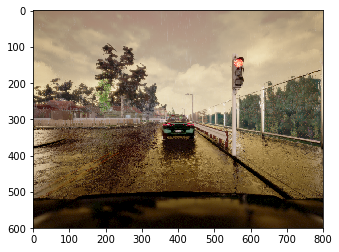

In [18]:
f = np.random.choice(os.listdir(label_url))
img = cv2.imread(os.path.join(img_url, f))
label = cv2.imread(os.path.join(label_url, f))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

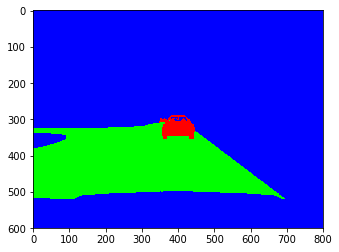

In [19]:
plt.imshow(process_label(label) )

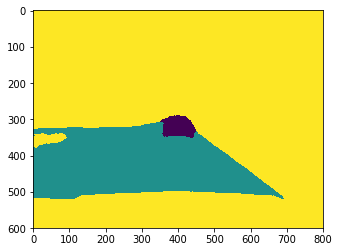

In [20]:
test_x = np.zeros((1, 600, 800, 3)).astype('float')
test_x[0, :, : ,: ] = img
test_x = test_x/255. - 0.5
#model = load_model("m2")
test_sample = model.predict(test_x)
final = test_sample.argmax(axis=2).reshape((1, 600, 800))[0]
plt.imshow(final)